# Simple exercises with Shapely + OpenCV (may not end up using)

In [2]:
from shapely.geometry import Point, LineString, Polygon
import shapely
import numpy as np

# Create a point
p = Point(4, 5)
print("Point:", p)

# Create a line
line = LineString([(0, 0), (2, 3), (4, 5)])
geoms = np.array([Point(0, 0), Point(1, 1.5), Point(20,5)])
print(shapely.intersects(line, geoms))


print("Line length:", line.length)

# Create a polygon
polygon = Polygon([(0, 0), (4, 0), (4, 4), (0, 4)])
print("Polygon area:", polygon.area)
print("Polygon centroid:", polygon.centroid)

Point: POINT (4 5)
[ True  True False]
Line length: 6.433978400210179
Polygon area: 16.0
Polygon centroid: POINT (2 2)


In [3]:
import numpy as np
import cv2
from shapely.geometry import Polygon, LineString
from skimage.morphology import skeletonize

# Create a binary mask (simulated epithelium region)
mask = np.zeros((100, 100), dtype=np.uint8)
#it goes top left to bottom right and 255 is white (ROI) while zero is black (background) 
cv2.rectangle(mask, (20, 20), (80, 80), 255, -1)  # Simulated epithelium region

# Skeletonize the mask (find the centerline)
binary_mask = (mask > 0).astype(np.uint8)  # Ensure binary (0 or 1)
print("binary_mask", binary_mask)
#print with label 
skeleton = skeletonize(binary_mask)
print("skeleton", skeleton)
#print space before next output
print()
# Extract skeleton coordinates
skeleton_coords = np.column_stack(np.where(skeleton > 0))
print("skeleton_coords")
print(skeleton_coords)
print(skeleton_coords.shape)
print()
#it iterates through the skeleton_coords which are lists, then it splices the list starting from the end and then it converts it to a tuple
centerline = LineString([tuple(coord[::-1]) for coord in skeleton_coords])
print(centerline)
print("Centerline Length:", centerline.length)


binary_mask [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
skeleton [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

skeleton_coords
[[49 50]
 [49 51]
 [50 49]]
(3, 2)

LINESTRING (50 49, 51 49, 49 50)
Centerline Length: 3.23606797749979


# Loading the Data + getting areas

In [4]:
# #loading the data BUT we do not have a WSI image...
# import slideflow as sf
# import matplotlib.pyplot as plt

# # Load the Whole Slide Image (WSI) & ROIs
# path = "/Users/sheeltanna/Cancer_Project_2025/AG037F.csv"  # Adjust if needed
# wsi = sf.WSI(path, 256, 128, rois='AG037F.csv')

# # # Extract polygons
# # rois = [roi.poly for roi in wsi.rois]  # List of Shapely Polygon objects

# # # Print areas of each ROI
# # for i, poly in enumerate(rois):
# #     print(f"ROI {i+1} Area: {poly.area}")


In [5]:
#alternative method for loading the data
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "/Users/sheeltanna/Cancer_Project_2025/Cancer_Project_2025/AG037F.csv"
df = pd.read_csv(csv_path)

# Group points by ROI name
roi_polygons = {}
#note that groupby is grouping by the roi_name column
#note that group is just a subset of the dataframe corresponding to the roi_name
for roi_name, group in df.groupby("roi_name"):
    #taking the two series of x and y coordinates and zipping them together. Zip needs two interables and makes tuples
    points = list(zip(group["x_base"], group["y_base"]))  # Convert to (x, y) coordinates
    #adding to the dictionary
    roi_polygons[roi_name] = Polygon(points)  # Create Shapely Polygon

#pritning dictionary here
for roi, poly in roi_polygons.items():
    print(f"ROI {roi}: Area = {poly.area}, Length = {poly.length}")


ROI ROI_1: Area = 2502597.5, Length = 8623.268285663553
ROI ROI_11: Area = 9879624.5, Length = 20163.19792633279
ROI ROI_12: Area = 3941817.5, Length = 11004.80563576758
ROI ROI_13: Area = 6565540.0, Length = 19588.338142361168
ROI ROI_15: Area = 9916.0, Length = 582.7230085110544
ROI ROI_19: Area = 26920015.380076278, Length = 56012.26676270695
ROI ROI_20: Area = 17691922.5, Length = 40760.771033223624
ROI ROI_21: Area = 12163178.849726776, Length = 32331.874440477695
ROI ROI_3: Area = 1775078.5, Length = 5639.798155264295
ROI ROI_4: Area = 9701082.0, Length = 17040.48556076896
ROI ROI_6: Area = 9253181.0, Length = 11814.963681904235
ROI ROI_7: Area = 18724605.413780596, Length = 45251.76238768894


# Visualzing the polygons

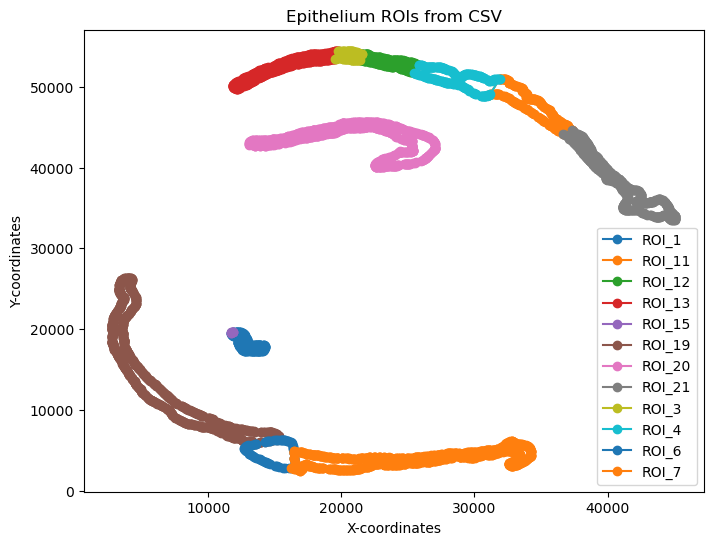

In [6]:
#visualizing the polygons
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each ROI polygon
#the .items provides tuples that we are interting through that represent the key value pairs in the dictionary
for roi_name, poly in roi_polygons.items():
    #gives two arrays of x and y coordinates
    x, y = poly.exterior.xy  # Extract X, Y coordinates
    ax.plot(x, y, linestyle="-", marker="o", label=roi_name)

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Epithelium ROIs from CSV")
plt.legend()
plt.show()


# Simple midpoint method
To get the centerline through the ROI which represent the epithelium region. 

True Centerline Length: 8523.608550212573


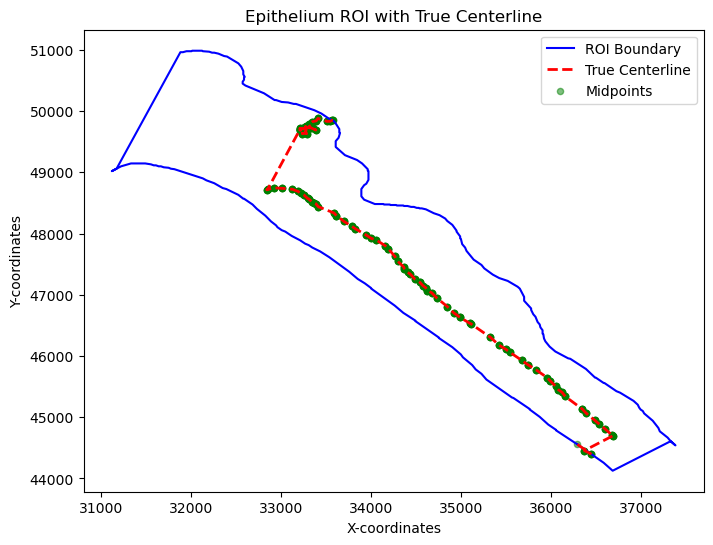

In [7]:
#getting centerline with simple method + visualizing it
from shapely.geometry import Polygon, LineString, MultiLineString
from shapely.ops import unary_union
import numpy as np
import matplotlib.pyplot as plt

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_11"]  # Replace with different ROI if needed

# Step 1: Get equally spaced points along the exterior
num_points = 1000  # Adjust for more precision
exterior_coords = np.array(roi_polygon.exterior.coords)
indices = np.linspace(0, len(exterior_coords) - 1, num_points, dtype=int)
sampled_points = exterior_coords[indices]

# Step 2: Find midpoints between opposite points on the boundary
midpoints = []
for i in range(len(sampled_points) // 2):
    x_mid = (sampled_points[i][0] + sampled_points[-(i + 1)][0]) / 2
    y_mid = (sampled_points[i][1] + sampled_points[-(i + 1)][1]) / 2
    midpoints.append((x_mid, y_mid))

# Step 3: Convert midpoints into a LineString
centerline = LineString(midpoints)

# Step 4: Measure the centerline length
print("True Centerline Length:", centerline.length)

# Step 5: Visualize ROI boundary and the extracted centerline
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROI boundary
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

# Plot Centerline
x_c, y_c = centerline.xy
ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="True Centerline")

# Plot midpoints
midpoints_array = np.array(midpoints)
ax.scatter(midpoints_array[:,0], midpoints_array[:,1], color='green', s=20, alpha=0.5, label='Midpoints')

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Epithelium ROI with True Centerline")
plt.legend()
plt.show()


# More complex voronoi method

Not terrible but lots of branching!! 
Tested multiple ROIs and the centerline always present but still lots of branching --> need to smooth

Voronoi Medial Axis Length: 32737.314621862784


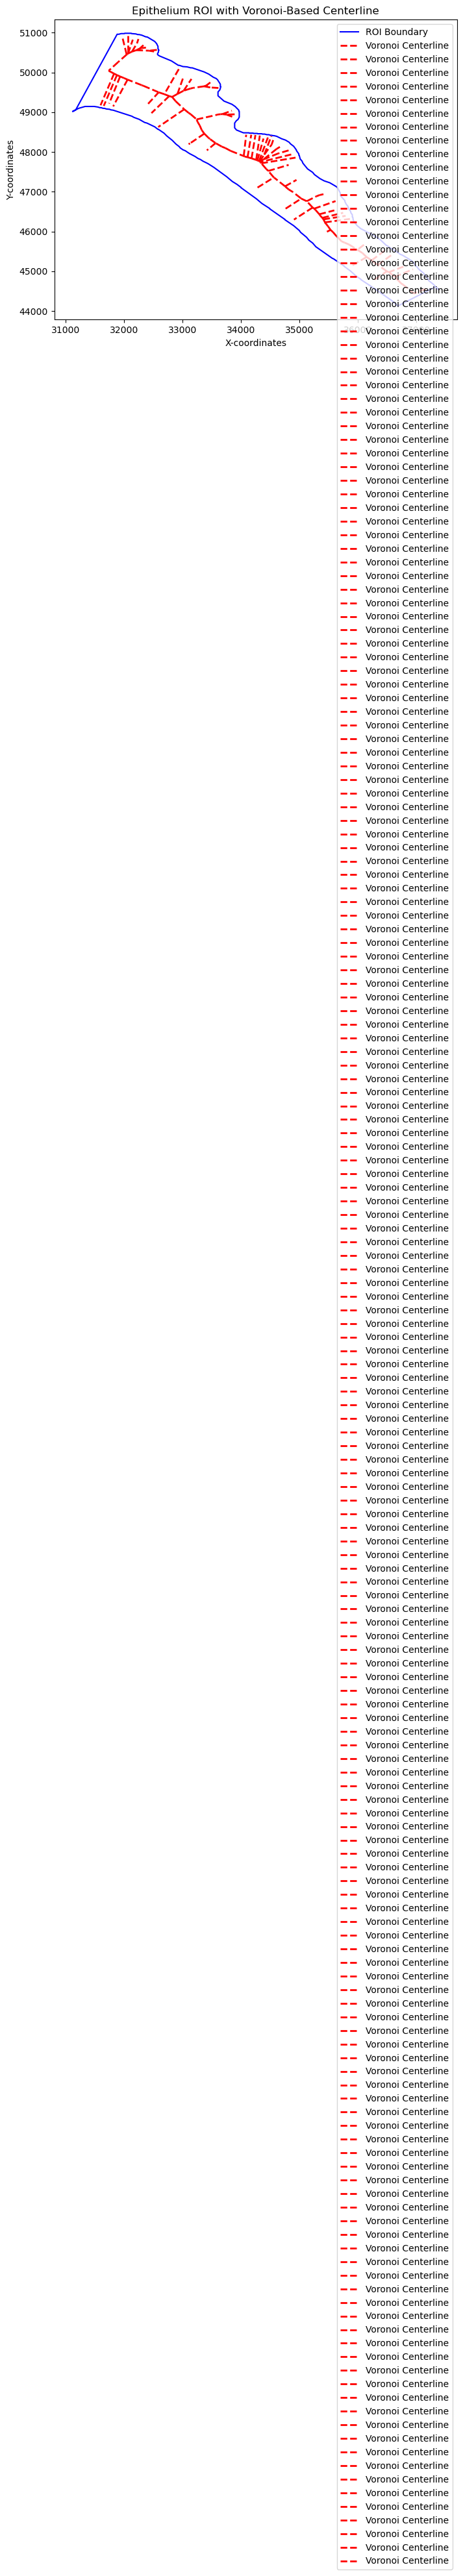

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiLineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi

# Select an example ROI polygon
roi_polygon = roi_polygons["ROI_11"]  # Replace with different ROI if needed

# Step 1: Extract boundary points from the polygon
boundary_coords = np.array(roi_polygon.exterior.coords)

# Step 2: Compute Voronoi diagram from boundary points
vor = Voronoi(boundary_coords)

# Step 3: Extract Voronoi edges and filter only those inside the polygon
valid_lines = []
for vpair in vor.ridge_vertices:
    if -1 in vpair:  # Ignore edges that extend to infinity
        continue
    p1, p2 = vor.vertices[vpair[0]], vor.vertices[vpair[1]]
    line = LineString([p1, p2])
    
    # Keep the line only if it's fully inside the polygon
    if roi_polygon.contains(line):
        valid_lines.append(line)

# Step 4: Merge all valid Voronoi lines into a single MultiLineString
medial_axis = unary_union(valid_lines)

# Step 5: Compute centerline length
print("Voronoi Medial Axis Length:", medial_axis.length)

# Step 6: Plot the ROI and the extracted medial axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROI boundary
x, y = roi_polygon.exterior.xy
ax.plot(x, y, linestyle="-", color="blue", label="ROI Boundary")

# Plot Centerline (Medial Axis)
if isinstance(medial_axis, MultiLineString):
    for line in medial_axis.geoms:
        x_c, y_c = line.xy
        ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="Voronoi Centerline")
else:
    x_c, y_c = medial_axis.xy
    ax.plot(x_c, y_c, linestyle="--", color="red", linewidth=2, label="Voronoi Centerline")

plt.xlabel("X-coordinates")
plt.ylabel("Y-coordinates")
plt.title("Epithelium ROI with Voronoi-Based Centerline")
plt.legend()
plt.show()
